# Softmax Regression

### **Importing**
We first import all the necessary packages

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from keras.utils import to_categorical
import csv
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
import time   # Used to time functions
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

### **Softmax Regression**

We first implement the class SoftmaxRegression using the template provided. It has 3 functions:

*   `softmax(x,w)` which applies the softmax function to the rows of $XW$

*   `fit(x,y,optimizer)`, which takes an optimizer object (i.e GradientDescent) and fits the data using the optimizer. 
*   `predict(x)`, which takes in new data and predicts the class labels.



In [77]:
class SoftmaxRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass

    # First computes x@w and then applies the softmax function on each
    # datapoint (every row)
    def softmax(x, w):
        
        def f(z):        
          yh_c = np.divide(np.exp(z), np.sum(np.exp(z)))
          return yh_c
        
        z_arr = x@w
        yh = np.apply_along_axis(f, 1, z_arr)

        return yh
    
    # Fits the model to the data. The validation sets are optional and are
    # required only if tracking validation accuracy as a termination condition
    # is desired (Required analysis part 2)
    def fit(self, x_train, y_train, optimizer, x_validate=[], y_validate=[]):
        if x_train.ndim == 1:
            x_train = x_train[:, None]
        if self.add_bias:
            N = x_train.shape[0]
            x_train = np.column_stack([x_train,np.ones(N)])
            if x_validate != []:           
                N = x_validate.shape[0]
                x_validate = np.column_stack([x_validate,np.ones(N)])        
        
        # Define the gradient function  
        def gradient(x, y, w):          
            yh = SoftmaxRegression.softmax(x,w)
            N = x.shape[0]
            grad = np.dot(x.T, yh - y)/N
            return grad
        
        # Initialize the weights as a DxC matrix of zeroes
        D = x_train.shape[1]
        C = y_train.shape[1]
        w0 = np.zeros((D,C))

        # Different configurations are run depending on whether a validation 
        # set is provided 
        if x_validate != []:
            self.w = optimizer.run(gradient, x_train, y_train, w0,
                                   x_validate, y_validate)
        else:
            self.w = optimizer.run(gradient, x_train, y_train, w0)

        # Calculate the cost        
        def log_sum_exp(z):
            max_zc = np.max(z)
            sum = 0
            for c in z:
                sum += np.exp(c-max_zc)
            logsum = max_zc + np.log(sum)
            return logsum        
        
        loglikelihood = 0        
        z = x_train@self.w
        N = x_train.shape[0]
        for i in range(0,N):
            loglikelihood += np.dot(y_train[i],z[i]) - log_sum_exp(z[i])
        
        cost = -1*loglikelihood


        return self, cost

    # Predicts with the optimized w
    def predict(self, x):        
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        
        yh = SoftmaxRegression.softmax(x, self.w)

        return yh


### **Gradient Descent**

We implement the GradientDescent class using the provided template. We are doing gradient descent with momentum and mini-batches. This class has 2 main functions:

*   `momentumGD()`, which implements gradient descent with momentum and mini-batches.
*   `run()`, which runs the optimization by calling `momentumGD()`.



In [78]:
class GradientDescent:

    def __init__(self, batch_size=1,learning_rate=0.01, momentum=0.9, 
                 max_iters=500, epsilon=1e-3, early_stop=True,
                 record_history=False):
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.early_stop=early_stop
        self.record_history = record_history
        if record_history:
            self.w_history = []

    '''
    run() runs in 2 different ways:
    (1) with validation sets that are used to calculate the accuracy at each
    iteration of gradient descent. If the accuracy doesn't change after 20
    iterations, gradient descent stops. (Part 2 of Required Analysis)
    (2) without validation sets, which is the default    
    '''
    def run(self, gradient_fn, x_train, y_train, w,
            x_validate=[], y_validate=[]):

        # Create a generator that will provide the weights at each iteration
        ws = self.momentumGD(gradient_fn, x_train, y_train, w)

        # (1) with validation sets and early Termination Condition
        if x_validate != [] and self.early_stop:
            # Initialize max_accuracy and max_w. max_w stores the weights that
            # provided the highest validation accuracy
            D, C = w.shape
            max_accuracy = 0
            max_w = np.zeros((D,C))
            num_iter = 0
            for curr_w in ws:
                # If gradient descent was iterated 20 times without seeing an
                # improvement, end it and return max_w. This only occurs
                # if early stop is true. 
                if num_iter > 20: break

                # Calculate yh (prediction). If the accuracy is higher than
                # max_accuracy, set max_w to the new w and reset num_iter
                yh = SoftmaxRegression.softmax(x_validate, curr_w)

                # Check accuracy and update the max_accuracy if appropriate
                acc = accuracy(yh,y_validate)
                if acc > max_accuracy:
                    max_accuracy = acc
                    max_w = curr_w
                    num_iter = 0    # Reset the counter
                else:
                    num_iter += 1

            return max_w

        # (2) without validation sets and early Termination Condition
        else:
            # Loop through all the weights to get to the last one
            last_w = None
            for curr_w in ws:
                last_w = curr_w
                
            return last_w


    # Creates a new set of mini-batches by shuffling the dataset and splitting
    # into num_batches batches.
    def get_new_minibatches(x, y, num_batches):
        # Shuffle the the datapoints in x and y
        shuffler = np.random.permutation(len(x))
        x = x[shuffler]
        y = y[shuffler]

        # Split x and y into minibatches of size B (approximately)
        x_B = np.array(np.array_split(x, num_batches, axis=0))
        y_B = np.array(np.array_split(y, num_batches, axis=0))

        return x_B, y_B

    # Performs gradient descent with momentum and mini-batches
    def momentumGD(self, gradient, x_orig, y_orig, w):
        # Preserve the original copies, because x and y will be randomly shuffled
        x = np.copy(x_orig)
        y = np.copy(y_orig)

        # Calculate the number of minibatches required
        num_batches = 0
        if (x.shape[0] % self.batch_size == 0):
            num_batches = int(x.shape[0]/self.batch_size)
        else:
            num_batches = int(x.shape[0]/self.batch_size) + 1

        # Initialize the set of minibatches that we will loop through
        x_B = []
        y_B = []
        
        # Initialize the gradient, gradient history and time
        grad = np.inf
        t = 1
        D,C = w.shape
        prev_w = np.copy(w)
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:

            # Get a new set of minibatches if all the previous ones have
            # been looped through
            if (t-1)%num_batches == 0:
                x_B, y_B = GradientDescent.get_new_minibatches(x, y, num_batches)

            # Calculate the gradient using the minibatch and add it to the history
            batch_index = (t-1)%num_batches

            grad = gradient(x_B[batch_index], y_B[batch_index], w)

            # This calculates the sum:
            # sum(from t=1 to T=t) beta^{T-t}*(1-beta)*delta_JB(w_t)
            # This sum is seen on slide 26 in the gradient descent lecture.
            delta_w = self.momentum * prev_w + (1-self.momentum) * grad          

            # Update prev_w and update w with delta_w, and add it to the history of w
            prev_w = np.copy(w)

            # Update w using delta_w
            w -= self.learning_rate * delta_w
            
            # Add to the history of w
            if self.record_history:
                self.w_history.append(w)

            t += 1    # increment the time by 1

            # The yield statement suspends function’s execution and sends a value
            # back to the caller but retains enough state information to enable
            # function to resume where it is left off
            yield w

# Hyper-parameters of the optimization procedure

### **Cross-validation**
We first define the functions that will calculate the optimal parameters using 5-fold cross validation. We will be finding optimal hyperparameters for the batch size, learning rate and momentum. We first define the functions:


*   `cross_validate()` which splits the data into n folds (in our case it's 5)
*   `optimize_hyperparams()` which optimizes the hyperparameters via grid search



In [79]:
# Calculates the accuracy (as a percentage of correct classifications)
def accuracy(yh, y):
    num_matches = 0    # Keep a counter for the number of missclassifications
    
    # Check if yh is one-dimensional or not. One dimensional arrays and 
    # matricies requires different processing methods
    if yh.ndim == 1:
        if np.argmax(yh) == np.argmax(y):
            return 100
        else:
            return 0
    else:        
        for i in range(0, len(yh)):
            if np.argmax(yh[i])==np.argmax(y[i]):
                num_matches +=1
    
        accuracy = (num_matches/len(yh)) * 100
        return accuracy

# Get train inds and val_inds
def cross_validate(n, n_folds=5):
    # Get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []    
    for f in range(n_folds):
        tr_inds = []
        
        # Get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        
        # Get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        
        yield tr_inds, val_inds

# Perform a grid search to find a good combination of batch size, learning rate,
# and momentum. 
def optimize_hyperparams(x, y, b_list, l_list, m_list, n_folds=5):
    num_instances, num_features = x.shape
    num_classes = y.shape[1]
    
    acc_valid = np.zeros((len(b_list)*len(l_list)*len(m_list), n_folds))
    max_accuracy = 0
    final_std = 0
    comb = np.zeros(3)
    num = 0
    for i, bs in enumerate(b_list):
        for j, lr in enumerate(l_list):
            for k, mt in enumerate(m_list):
                #Find the validation errors for n_folds splits for a given K
                for f, (tr, val) in enumerate(cross_validate(num_instances, n_folds)):
                    model = SoftmaxRegression()
                    optimizer = GradientDescent(batch_size=bs,learning_rate=lr,
                                                momentum=mt)                    
                    model.fit(x[tr],y[tr],optimizer,
                              x_validate=x[val],y_validate=y[val])
                              
                    yh = model.predict(x[val])
                    acc_valid[num, f] = accuracy(yh, y[val])

                mean_accuracy = np.mean(acc_valid[num])
                if mean_accuracy > max_accuracy:
                    max_accuracy = mean_accuracy
                    final_std = np.std(acc_valid[num])
                    comb[0] = bs
                    comb[1] = lr
                    comb[2] = mt
                num += 1
    
    print("Best parameters: batch_size = {}, learning_rate = {}, momentum = {}".format(comb[0],comb[1],comb[2]))
    print("Mean accuracy with these parameters:{:.2f}; Standard dev.: {:.2f}".format(max_accuracy,final_std))
    
    return comb,[max_accuracy, final_std]

### **Digits**
We load the digit dataset and extract x and y. We also one-hot encode y. Each label in y is an array of size 10. The array is 0 everywhere except for where the index matches the digit. For example, 
*   3 := [0,0,0,1,0,0,0,0,0,0]
*   9 := [0,0,0,0,0,0,0,0,0,1]
*   0 := [1,0,0,0,0,0,0,0,0,0]

We will find the optimal hyperparameters for batch size, learning rate and momentum. We will be doing a grid search on 5 possible values per hyper parameter.

In [80]:
digits = load_digits()
x_digits = digits['data']
y_digits = to_categorical(digits['target'])

b_list = [1,16,32,64,128]
l_list = [0.001,0.01,0.1,0.5]
m_list = [0.99,0.9,0.8,0.5]

# # Use these lists if you want it to finish faster
# b_list = [5,100]
# l_list = [0.001,0.01]
# m_list = [0.99,0.95]

# Find the optimal parameters via grid search.

# opt_hyperp_digits[0]:=batch_size 
# opt_hyperp_digits[1]:=learning_rate
# opt_hyperp_digits[2]:=momentum
t0 = time.time()
opt_hyperp_digits,acc_digits_sm = optimize_hyperparams(x_digits,y_digits, 
                                                      b_list,l_list,m_list)
t1 = time.time()

m, s = divmod(t1-t0, 60)
print("Time elapsed: {} min {:.3f} seconds".format(m,s))


Best parameters: batch_size = 128.0, learning_rate = 0.01, momentum = 0.5
Mean accuracy with these parameters:91.25; Standard dev.: 2.24
Time elapsed: 2.0 min 49.255 seconds


### **Semeion Digit Dataset**
We load the digit dataset of Semeion Research Center of Sciences of Communication at the University of California Irvine. The classes are the same as the MNIST digit dataset, except the class '0' is replaced by '10'. There are 256 features, each representing the intensity of a pixel in a 16x16 image

We will find the optimal hyperparameters for batch size, learning rate and momentum. We will be doing a grid search on 5 possible values per hyper parameter.

In [81]:
# Using the csv library, directly copy the dataset into a list, then convert into a numpy array
semeion = list(csv.reader(open("semeion.csv")))
semeion = np.array(semeion)

# Save the header of the csv file and then remove it from the array
semeion_header = semeion[0,:]
semeion = semeion[1::,:]

# Extract X and Y out of the dataset
np.random.shuffle(semeion)
x_semeion = semeion[:,0:(semeion.shape[1] - 1)].astype(np.float)
y_semeion = np.reshape(semeion[:,semeion.shape[1] - 1], (semeion.shape[0], 1))
y_semeion = y_semeion.astype(np.int)

# Because datasets labels are loaded as being from 1-10, we want 0-9
y_semeion[y_semeion > 9] = 0

# One hot encode it using to_categorical
y_semeion = to_categorical(y_semeion)

# Find the optimal parameters
# opt_hyperp_semeion = np.zeros(3)

# opt_hyperp_semeion[0]:=batch_size
# opt_hyperp_semeion[1]:=learning_rate
# opt_hyperp_semeion[2]:=momentum
t0 = time.time()
opt_hyperp_semeion,acc_semeion_sm = optimize_hyperparams(x_semeion,y_semeion, 
                                                          b_list,l_list,m_list)
t1 = time.time()

m, s = divmod(t1-t0, 60)
print("Time elapsed: {} min {:.3f} seconds".format(m,s))


Best parameters: batch_size = 128.0, learning_rate = 0.1, momentum = 0.5
Mean accuracy with these parameters:79.56; Standard dev.: 1.78
Time elapsed: 3.0 min 44.940 seconds


### **Satellite Image Dataset**
We load a satellite image dataset created by Dr. Ashwin Srinivasan from the University of California Irvine. The data contains multi-spectral 3x3 images from satellites. The task is to determine the type of soil in the central pixel. There are 36 attributes representing 4 spectral bands and 9 pixels. There are 6 classes: red soil, cotton crop, grey soil, damp grey soil, soil with vegetation stubble, and very damp grey soil.  


In [82]:
# Using the csv library, directly copy the dataset into a list, then convert into a numpy array
satimage = list(csv.reader(open("satimage.csv")))
satimage = np.array(satimage)

# Save the header of the csv file and then remove it from the array
satimage_header = satimage[0,:]
satimage = satimage[1::,:]

# Extract X and Y out of the dataset
np.random.shuffle(satimage)
x_satimage = satimage[:,0:(satimage.shape[1] - 1)].astype(np.float)
y_satimage = np.reshape(satimage[:,satimage.shape[1] - 1], (satimage.shape[0], 1))
y_satimage = y_satimage.astype(np.float).astype(np.int)

# Because datasets labels are loaded as being from 1-10, we want 0-9
y_satimage[y_satimage > 6] = 0

# One hot encode it using to_categorical
y_satimage = to_categorical(y_satimage,num_classes=6)

# Find the optimal parameters
# opt_hyperp_satimage = np.zeros(3)

# opt_hyperp_satimage[0]:=batch_size
# opt_hyperp_satimage[1]:=learning_rate
# opt_hyperp_satimage[2]:=momentum
t0 = time.time()
opt_hyperp_satimage,acc_satimage_sm = optimize_hyperparams(x_satimage,y_satimage, 
                                                            b_list,l_list,m_list)
t1 = time.time()

m, s = divmod(t1-t0, 60)
print("Time elapsed: {} min {:.3f} seconds".format(m,s))

Best parameters: batch_size = 16.0, learning_rate = 0.5, momentum = 0.5
Mean accuracy with these parameters:75.85; Standard dev.: 3.58
Time elapsed: 10.0 min 22.175 seconds


### **Effect of batch size on run-time and performance**
We will now create plots for each hypeparameter and see how they affect the mean accuracy and runtime while holding the other hyperparameters constant. We start with the analysis of batch size.

In [83]:
# Create a list of batch sizes, from 1 to N incrementing by 50
b_list_digits = np.array(range(1,130,8))
b_list_semeion = np.array(range(1,130,8))
b_list_satimage = np.array(range(1,130,8))

def acc_bsizes(x, y, b_list,learning_rate, momentum):

    runtime_list = np.zeros((2,len(b_list)))    # List where we store the runtime
    acc_val_list = np.zeros((2,len(b_list)))    # Lists where we store our accuracies
    acc_train_list = np.zeros((2,len(b_list)))
    cost_list = np.zeros((2,len(b_list)))
    acc_test_list = np.zeros(len(b_list))

    num_instances, num_features = x.shape
    num_classes = y.shape[1]
    inds = np.random.permutation(num_instances)
    n_test = num_instances // 5
    
    # Seperate the test data
    x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
    x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]
    # Rest for training and validation
    n_rest = num_instances - n_test
    # Iterate through the b_list and use 5-fold cross valdiation to get the accuracy,
    # runtime, and cost.
    for i, b in enumerate(b_list):  
        # Initialize arrays that will store the runtime and accuracy of each fold
        rt_crss_val = np.zeros(5)
        acc_val_crss_val = np.zeros(5)
        acc_train_crss_val = np.zeros(5)
        cost_crss_val = np.zeros(5)
        for f, (tr, val) in enumerate(cross_validate(n_rest, 5)):
            t0 = time.time()    # Start the timer
            model = SoftmaxRegression()
            optimizer = GradientDescent(batch_size=b,learning_rate=learning_rate,
                                        momentum=momentum,early_stop=False)            
            cost = model.fit(x_rest[tr],y_rest[tr],optimizer,x_validate=x_rest[val],y_validate=y_rest[val])
            t1 = time.time()    # Stop the timer
            
            yh_val = model.predict(x_rest[val])
            yh_train = model.predict(x_rest[tr])

            # Append the runtime and accuracy
            rt_crss_val[f] = t1-t0
            acc_val_crss_val[f] = accuracy(yh_val, y_rest[val])
            acc_train_crss_val[f] = accuracy(yh_train, y_rest[tr])
            cost_crss_val[f] = cost[1]

        # Store the average runtime and mean
        runtime_list[0][i] = np.mean(rt_crss_val)
        runtime_list[1][i] = np.std(rt_crss_val)
        acc_val_list[0][i] = np.mean(acc_val_crss_val)
        acc_val_list[1][i] = np.std(acc_val_crss_val)
        acc_train_list[0][i] = np.mean(acc_train_crss_val)
        acc_train_list[1][i] = np.std(acc_train_crss_val)
        cost_list[0][i] = np.mean(cost_crss_val)
        cost_list[1][i] = np.std(cost_crss_val)

        # Get the test accuracy
        model = SoftmaxRegression()
        optimizer = GradientDescent(batch_size=b,learning_rate=learning_rate,
                                        momentum=momentum,early_stop=False)  
        cost = model.fit(x_rest,y_rest,optimizer)
        yh_test = model.predict(x_test)
        acc_test = accuracy(yh_test,y_test)
        acc_test_list[i] = acc_test

    return [acc_val_list, acc_train_list, acc_test_list, runtime_list, cost_list]

digits_out = acc_bsizes(x_digits, y_digits,b_list_digits,
                        opt_hyperp_digits[1],opt_hyperp_digits[2])
semeion_out = acc_bsizes(x_semeion, y_semeion, b_list_semeion,
                         opt_hyperp_semeion[1],opt_hyperp_semeion[2])
satimage_out = acc_bsizes(x_satimage, y_satimage, b_list_satimage,
                          opt_hyperp_satimage[1],opt_hyperp_satimage[2])

acc_val_digits,acc_train_digits,acc_test_digits = digits_out[0], digits_out[1], digits_out[2]
rt_digits = digits_out[3]
cost_digits = digits_out[4]

acc_val_semeion,acc_train_semeion,acc_test_semeion = semeion_out[0], semeion_out[1], semeion_out[2]
rt_semeion = semeion_out[3]
cost_semeion = semeion_out[4]

acc_val_satimage,acc_train_satimage,acc_test_satimage = satimage_out[0], satimage_out[1], satimage_out[2]
rt_satimage = satimage_out[3]
cost_satimage = satimage_out[4]


The results are plotted. The error bars represent the standard deviation.

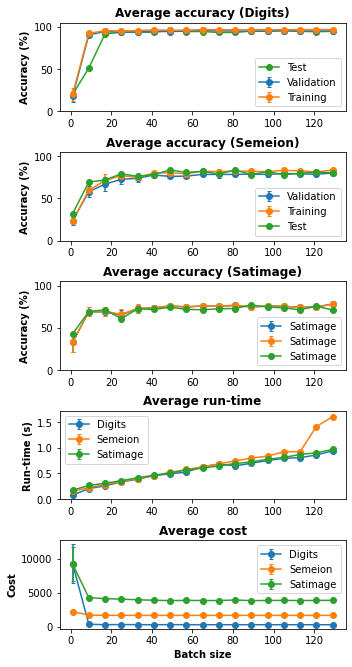

In [84]:
# Plot the results
fig, axs = plt.subplots(5,1,figsize=(5,10))

plt.subplot(5,1,1)
plt.errorbar(b_list_digits, acc_val_digits[0], yerr=acc_val_digits[1], 
             fmt='o',label='Validation',capsize=2,linestyle='-')
plt.errorbar(b_list_digits, acc_train_digits[0], yerr=acc_train_digits[1], 
             fmt='o',label='Training',capsize=2,linestyle='-')
plt.plot(b_list_digits, acc_test_digits, marker='o',label='Test')
# plt.xlabel('Batch size', fontweight='bold')
plt.ylabel('Accuracy (%)', fontweight='bold')
plt.title('Average accuracy (Digits)', fontweight='bold')
plt.legend()
plt.autoscale()
plt.ylim((0, 105))

plt.subplot(5,1,2)
plt.errorbar(b_list_semeion, acc_val_semeion[0], yerr=acc_val_semeion[1], 
             fmt='o',label='Validation',capsize=2,linestyle='-')
plt.errorbar(b_list_semeion, acc_train_semeion[0], yerr=acc_train_semeion[1], 
             fmt='o',label='Training',capsize=2,linestyle='-')
plt.errorbar(b_list_semeion, acc_test_semeion, marker='o',label='Test')
# plt.xlabel('Batch size', fontweight='bold')
plt.ylabel('Accuracy (%)', fontweight='bold')
plt.title('Average accuracy (Semeion)', fontweight='bold')
plt.legend()
plt.autoscale()
plt.ylim((0, 105))

plt.subplot(5,1,3)
plt.errorbar(b_list_satimage, acc_val_satimage[0], yerr=acc_val_satimage[1], 
             fmt='o',label='Satimage',capsize=2,linestyle='-')
plt.errorbar(b_list_satimage, acc_train_satimage[0], yerr=acc_train_satimage[1], 
             fmt='o',label='Satimage',capsize=2,linestyle='-')
plt.errorbar(b_list_satimage, acc_test_satimage, marker='o',label='Satimage')
# plt.xlabel('Batch size', fontweight='bold')
plt.ylabel('Accuracy (%)', fontweight='bold')
plt.title('Average accuracy (Satimage)', fontweight='bold')
plt.legend()
plt.autoscale()
plt.ylim((0, 105))

plt.subplot(5,1,4)
plt.errorbar(b_list_digits, rt_digits[0], yerr=rt_digits[1], 
             fmt='o',label='Digits',capsize=2,linestyle='-')
plt.errorbar(b_list_semeion, rt_semeion[0], yerr=rt_semeion[1], 
             fmt='o',label='Semeion',capsize=2,linestyle='-')
plt.errorbar(b_list_satimage, rt_satimage[0], yerr=rt_satimage[1], 
             fmt='o',label='Satimage',capsize=2,linestyle='-')
# plt.xlabel('Batch size', fontweight='bold')
plt.ylabel('Run-time (s)', fontweight='bold')
plt.title('Average run-time', fontweight='bold')
plt.legend()
plt.autoscale()

plt.subplot(5,1,5)
plt.errorbar(b_list_digits, cost_digits[0], yerr=cost_digits[1], 
             fmt='o',label='Digits',capsize=2,linestyle='-')
plt.errorbar(b_list_semeion, cost_semeion[0], yerr=cost_semeion[1], 
             fmt='o',label='Semeion',capsize=2,linestyle='-')
plt.errorbar(b_list_satimage, cost_satimage[0], yerr=cost_satimage[1], 
             fmt='o',label='Satimage',capsize=2,linestyle='-')
plt.xlabel('Batch size', fontweight='bold')
plt.ylabel('Cost', fontweight='bold')
plt.title('Average cost', fontweight='bold')
plt.legend()
plt.autoscale()

plt.tight_layout()
plt.subplots_adjust(top=0.9)

We see that the algorithm does not converge if the batch size is 1. We will attempt to make it converge by lowering the learning rate and increasing the momentum.

### **Effect of learning rate on run-time and performance**
We continue with the analysis of the learning rate.

In [85]:
# Create a list of learning rates
l_list = []
for i in range(-4,2):
    l_list.append([j*10**i for j in range(1,10)])
l_list = np.sort(np.array(np.array(l_list).flat))

def acc_lr(x, y, l_list,batch_size, momentum):
    runtime_list = np.zeros((2,len(l_list)))    # List where we store the runtime
    acc_val_list = np.zeros((2,len(l_list)))    # Lists where we store our accuracies
    acc_train_list = np.zeros((2,len(l_list)))
    cost_list = np.zeros((2,len(l_list)))
    acc_test_list = np.zeros(len(l_list))

    num_instances, num_features = x.shape
    num_classes = y.shape[1]
    inds = np.random.permutation(num_instances)
    n_test = num_instances // 5
    
    # Seperate the test data
    x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
    x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]
    # Rest for training and validation
    n_rest = num_instances - n_test
    # Iterate through the l_list and use 5-fold cross valdiation to get the accuracy,
    # runtime, and cost.
    for i, lr in enumerate(l_list):  
        # Initialize arrays that will store the runtime and accuracy of each fold
        rt_crss_val = np.zeros(5)
        acc_val_crss_val = np.zeros(5)
        acc_train_crss_val = np.zeros(5)
        cost_crss_val = np.zeros(5)
        for f, (tr, val) in enumerate(cross_validate(n_rest, 5)):
            t0 = time.time()    # Start the timer
            model = SoftmaxRegression()
            optimizer = GradientDescent(batch_size=batch_size,learning_rate=lr,
                                        momentum=momentum,early_stop=False)            
            cost = model.fit(x_rest[tr],y_rest[tr],optimizer,x_validate=x_rest[val],y_validate=y_rest[val])
            t1 = time.time()    # Stop the timer
            
            yh_val = model.predict(x_rest[val])
            yh_train = model.predict(x_rest[tr])
            # Append the runtime and accuracy
            rt_crss_val[f] = t1-t0
            acc_val_crss_val[f] = accuracy(yh_val, y_rest[val])
            acc_train_crss_val[f] = accuracy(yh_train, y_rest[tr])
            cost_crss_val[f] = cost[1]

        # Store the average runtime and mean
        runtime_list[0][i] = np.mean(rt_crss_val)
        runtime_list[1][i] = np.std(rt_crss_val)
        acc_val_list[0][i] = np.mean(acc_val_crss_val)
        acc_val_list[1][i] = np.std(acc_val_crss_val)
        acc_train_list[0][i] = np.mean(acc_train_crss_val)
        acc_train_list[1][i] = np.std(acc_train_crss_val)
        cost_list[0][i] = np.mean(cost_crss_val)
        cost_list[1][i] = np.std(cost_crss_val)

        # Get the test accuracy
        model = SoftmaxRegression()
        optimizer = GradientDescent(batch_size=batch_size,learning_rate=lr,
                                        momentum=momentum,early_stop=False)  
        cost = model.fit(x_rest,y_rest,optimizer)
        yh_test = model.predict(x_test)
        acc_test = accuracy(yh_test,y_test)
        acc_test_list[i] = acc_test

    return [acc_val_list, acc_train_list, acc_test_list, runtime_list, cost_list]

digits_out = acc_lr(x_digits, y_digits,l_list,
                        opt_hyperp_digits[0],opt_hyperp_digits[2])
semeion_out = acc_lr(x_semeion, y_semeion, l_list,
                         opt_hyperp_semeion[0],opt_hyperp_semeion[2])
satimage_out = acc_lr(x_satimage, y_satimage, l_list,
                          opt_hyperp_satimage[0],opt_hyperp_satimage[2])

acc_val_digits,acc_train_digits,acc_test_digits = digits_out[0], digits_out[1], digits_out[2]
rt_digits = digits_out[3]
cost_digits = digits_out[4]

acc_val_semeion,acc_train_semeion,acc_test_semeion = semeion_out[0], semeion_out[1], semeion_out[2]
rt_semeion = semeion_out[3]
cost_semeion = semeion_out[4]

acc_val_satimage,acc_train_satimage,acc_test_satimage = satimage_out[0], satimage_out[1], satimage_out[2]
rt_satimage = satimage_out[3]
cost_satimage = satimage_out[4]

The results are plotted:

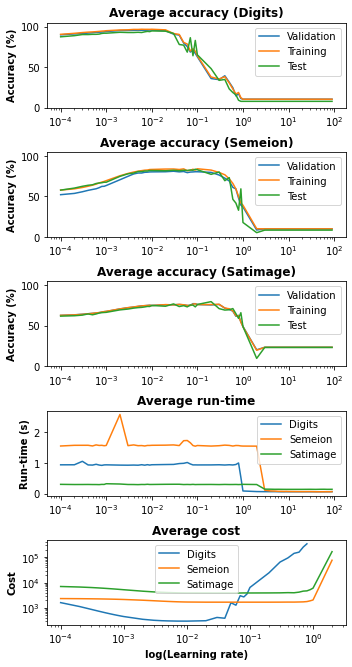

In [86]:
# Plot the results
plt.subplots(5,1,figsize=(5,10))

plt.subplot(5,1,1)
plt.plot(l_list, acc_val_digits[0], marker=None,label='Validation')
plt.plot(l_list, acc_train_digits[0], marker=None,label='Training')
plt.plot(l_list, acc_test_digits, marker=None,label='Test')
# plt.xlabel('log(Learning rate)', fontweight='bold')
plt.ylabel('Accuracy (%)', fontweight='bold')
plt.title('Average accuracy (Digits)', fontweight='bold')
plt.legend()
plt.autoscale()
plt.xscale('log')
plt.ylim((0, 105))

plt.subplot(5,1,2)
plt.plot(l_list, acc_val_semeion[0], marker=None,label='Validation')
plt.plot(l_list, acc_train_semeion[0], marker=None,label='Training')
plt.plot(l_list, acc_test_semeion, marker=None,label='Test')
# plt.xlabel('log(Learning rate)', fontweight='bold')
plt.ylabel('Accuracy (%)', fontweight='bold')
plt.title('Average accuracy (Semeion)', fontweight='bold')
plt.legend()
plt.autoscale()
plt.xscale('log')
plt.ylim((0, 105))

plt.subplot(5,1,3)
plt.plot(l_list, acc_val_satimage[0], marker=None,label='Validation')
plt.plot(l_list, acc_train_satimage[0], marker=None,label='Training')
plt.plot(l_list, acc_test_satimage, marker=None,label='Test')
# plt.xlabel('log(Learning rate)', fontweight='bold')
plt.ylabel('Accuracy (%)', fontweight='bold')
plt.title('Average accuracy (Satimage)', fontweight='bold')
plt.legend()
plt.autoscale()
plt.xscale('log')
plt.ylim((0, 105))

plt.subplot(5,1,4)
plt.plot(l_list, rt_digits[0], marker=None,label='Digits')
plt.plot(l_list, rt_semeion[0], marker=None,label='Semeion')
plt.plot(l_list, rt_satimage[0], marker=None,label='Satimage')
# plt.xlabel('log(Learning rate)', fontweight='bold')
plt.ylabel('Run-time (s)', fontweight='bold')
plt.title('Average run-time', fontweight='bold')
plt.legend()
plt.xscale('log')
plt.autoscale()

plt.subplot(5,1,5)
plt.plot(l_list, cost_digits[0], marker=None,label='Digits')
plt.plot(l_list, cost_semeion[0], marker=None,label='Semeion')
plt.plot(l_list, cost_satimage[0], marker=None,label='Satimage')
plt.xlabel('log(Learning rate)', fontweight='bold')
plt.ylabel('Cost', fontweight='bold')
plt.title('Average cost', fontweight='bold')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.autoscale()

plt.tight_layout()
plt.subplots_adjust(top=0.9)

### **Effect of momentum on run-time and performance**
We finally finish by examining the effect of momentum.

In [87]:
# Create a list momentums
m_list = [x / 10.0 for x in range(3, 10)]
m_list.extend([x / 100.0 for x in range(90, 100)])
m_list = np.array(m_list)

def acc_m(x, y, m_list, batch_size, learning_rate):
    runtime_list = np.zeros((2,len(m_list)))    # List where we store the runtime
    acc_val_list = np.zeros((2,len(m_list)))    # Lists where we store our accuracies
    acc_train_list = np.zeros((2,len(m_list)))
    cost_list = np.zeros((2,len(m_list)))
    acc_test_list = np.zeros(len(m_list))

    num_instances, num_features = x.shape
    num_classes = y.shape[1]
    inds = np.random.permutation(num_instances)
    n_test = num_instances // 5
    
    # Seperate the test data
    x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
    x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]
    # Rest for training and validation
    n_rest = num_instances - n_test
    # Iterate through the m_list and use 5-fold cross valdiation to get the accuracy,
    # runtime, and cost.
    for i, m in enumerate(m_list):  
        # Initialize arrays that will store the runtime and accuracy of each fold
        rt_crss_val = np.zeros(5)
        acc_val_crss_val = np.zeros(5)
        acc_train_crss_val = np.zeros(5)
        cost_crss_val = np.zeros(5)
        for f, (tr, val) in enumerate(cross_validate(n_rest, 5)):
            t0 = time.time()    # Start the timer
            model = SoftmaxRegression()
            optimizer = GradientDescent(batch_size=batch_size,learning_rate=learning_rate,
                                        momentum=m,early_stop=False)            
            cost = model.fit(x_rest[tr],y_rest[tr],optimizer,x_validate=x_rest[val],y_validate=y_rest[val])
            t1 = time.time()    # Stop the timer
            
            yh_val = model.predict(x_rest[val])
            yh_train = model.predict(x_rest[tr])
            # Append the runtime and accuracy
            rt_crss_val[f] = t1-t0
            acc_val_crss_val[f] = accuracy(yh_val, y_rest[val])
            acc_train_crss_val[f] = accuracy(yh_train, y_rest[tr])
            cost_crss_val[f] = cost[1]

        # Store the average runtime and mean
        runtime_list[0][i] = np.mean(rt_crss_val)
        runtime_list[1][i] = np.std(rt_crss_val)
        acc_val_list[0][i] = np.mean(acc_val_crss_val)
        acc_val_list[1][i] = np.std(acc_val_crss_val)
        acc_train_list[0][i] = np.mean(acc_train_crss_val)
        acc_train_list[1][i] = np.std(acc_train_crss_val)
        cost_list[0][i] = np.mean(cost_crss_val)
        cost_list[1][i] = np.std(cost_crss_val)

        # Get the test accuracy
        model = SoftmaxRegression()
        optimizer = GradientDescent(batch_size=batch_size,learning_rate=learning_rate,
                                        momentum=m,early_stop=False)  
        cost = model.fit(x_rest,y_rest,optimizer)
        yh_test = model.predict(x_test)
        acc_test = accuracy(yh_test,y_test)
        acc_test_list[i] = acc_test

    return [acc_val_list, acc_train_list, acc_test_list, runtime_list, cost_list]

digits_out = acc_m(x_digits, y_digits,m_list,
                        opt_hyperp_digits[0],opt_hyperp_digits[1])
semeion_out = acc_m(x_semeion, y_semeion, m_list,
                         opt_hyperp_semeion[0],opt_hyperp_semeion[1])
satimage_out = acc_m(x_satimage, y_satimage, m_list,
                          opt_hyperp_satimage[0],opt_hyperp_satimage[1])

acc_val_digits,acc_train_digits,acc_test_digits = digits_out[0], digits_out[1], digits_out[2]
rt_digits = digits_out[3]
cost_digits = digits_out[4]

acc_val_semeion,acc_train_semeion,acc_test_semeion = semeion_out[0], semeion_out[1], semeion_out[2]
rt_semeion = semeion_out[3]
cost_semeion = semeion_out[4]

acc_val_satimage,acc_train_satimage,acc_test_satimage = satimage_out[0], satimage_out[1], satimage_out[2]
rt_satimage = satimage_out[3]
cost_satimage = satimage_out[4]

We plot the results:

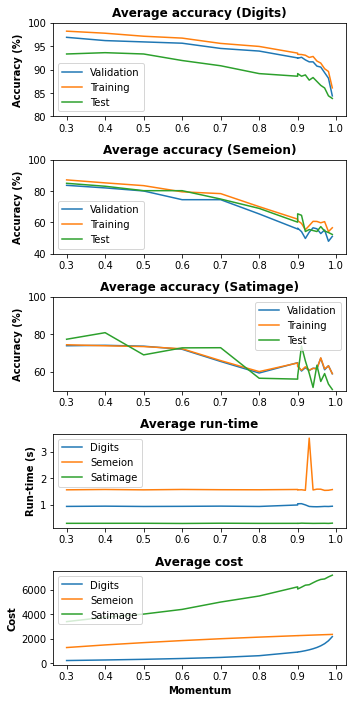

In [88]:
# Plot the results
plt.subplots(5,1,figsize=(5,10))

plt.subplot(5,1,1)
plt.plot(m_list, acc_val_digits[0], marker=None,label='Validation')
plt.plot(m_list, acc_train_digits[0], marker=None,label='Training')
plt.plot(m_list, acc_test_digits, marker=None,label='Test')
# plt.xlabel('log(Learning rate)', fontweight='bold')
plt.ylabel('Accuracy (%)', fontweight='bold')
plt.title('Average accuracy (Digits)', fontweight='bold')
plt.legend()
plt.autoscale()
plt.ylim((80, 100))

plt.subplot(5,1,2)
plt.plot(m_list, acc_val_semeion[0], marker=None,label='Validation')
plt.plot(m_list, acc_train_semeion[0], marker=None,label='Training')
plt.plot(m_list, acc_test_semeion, marker=None,label='Test')
# plt.xlabel('log(Learning rate)', fontweight='bold')
plt.ylabel('Accuracy (%)', fontweight='bold')
plt.title('Average accuracy (Semeion)', fontweight='bold')
plt.legend()
plt.autoscale()
plt.ylim((40, 100))

plt.subplot(5,1,3)
plt.plot(m_list, acc_val_satimage[0], marker=None,label='Validation')
plt.plot(m_list, acc_train_satimage[0], marker=None,label='Training')
plt.plot(m_list, acc_test_satimage, marker=None,label='Test')
plt.ylabel('Accuracy (%)', fontweight='bold')
plt.title('Average accuracy (Satimage)', fontweight='bold')
plt.legend()
plt.autoscale()
plt.ylim((50, 100))


plt.subplot(5,1,4)
plt.plot(m_list, rt_digits[0], marker=None,label='Digits')
plt.plot(m_list, rt_semeion[0], marker=None,label='Semeion')
plt.plot(m_list, rt_satimage[0], marker=None,label='Satimage')
# plt.xlabel('log(Learning rate)', fontweight='bold')
plt.ylabel('Run-time (s)', fontweight='bold')
plt.title('Average run-time', fontweight='bold')
plt.legend()
plt.autoscale()

plt.subplot(5,1,5)
plt.plot(m_list, cost_digits[0], marker=None,label='Digits')
plt.plot(m_list, cost_semeion[0], marker=None,label='Semeion')
plt.plot(m_list, cost_satimage[0], marker=None,label='Satimage')
plt.xlabel('Momentum', fontweight='bold')
plt.ylabel('Cost', fontweight='bold')
plt.title('Average cost', fontweight='bold')
plt.legend()
plt.autoscale()

plt.tight_layout()
plt.subplots_adjust(top=0.95)

### **Comparisons against other classifiers**
We will compare the accuracy of the decision trees against the three datasets

In [89]:
# Optimize the parameters of decision treens
def optimize_hyperparams_DT(x, y, criterion_list, max_depth_list, min_samples_split_list, min_samples_leaf_list, n_folds=5):
    num_instances, num_features = x.shape
    num_classes = y.shape[1]
    
    acc_valid = np.zeros((len(max_depth_list)*len(min_samples_split_list)*len(min_samples_leaf_list)*len(criterion_list), n_folds))
    max_accuracy = 0
    final_std = 0
    comb = []
    num = 0

    # Try every combination of hyperparameters
    for i, md in enumerate(max_depth_list):
        for j, ms in enumerate(min_samples_split_list):
            for k, ml in enumerate(min_samples_leaf_list):
                for n, ct in enumerate(criterion_list):
                    #Find the validation errors for n_folds splits for a given combination of parameters
                    for f, (tr, val) in enumerate(cross_validate(num_instances, n_folds)):
                        # Fit the model
                        model = DecisionTreeClassifier(criterion=ct,max_depth=md,min_samples_split=ms,min_samples_leaf=ml)                   
                        model.fit(x[tr],y[tr])
                        # Get the accuracy
                        yh = model.predict(x[val])
                        acc_valid[num, f] = accuracy(yh, y[val])
                    mean_accuracy = np.mean(acc_valid[num])
                    # Keep track of the max accuracy
                    if mean_accuracy > max_accuracy:
                        max_accuracy = mean_accuracy
                        final_std = np.std(acc_valid[num])
                        comb.append(ct)
                        comb.append(md)
                        comb.append(ms)
                        comb.append(ml)
                    num += 1
    
    print("Best parameters: criterion = {}, max_depth = {}, min_samples_split = {}, min_samples_leaf = {}".format(comb[0],comb[1],comb[2],comb[3]))
    print("Mean accuracy with these parameters:{:.2f}; SD: {}".format(max_accuracy,final_std))
    return comb, [max_accuracy,final_std]

#### Digits dataset
We calculate the maximum accuracy using decision trees on the digits dataset

In [90]:
criterion_list = ['gini','entropy']
max_depth_list = [None,3,5,10,15]
min_samples_list = [2,4,6]
min_samples_leaf_list = [1,2,4]

# opt_parameters_digits[0]:=criterion 
# opt_parameters_digits[1]:=max_depth
# opt_parameters_digits[2]:=min_samples_split
# opt_parameters_digits[3]:=min_samples_leaf
t0 = time.time()
opt_parameters_digits,acc_digits_dt = optimize_hyperparams_DT(x_digits,y_digits,criterion_list,max_depth_list,min_samples_list,min_samples_leaf_list)
t1 = time.time()
m, s = divmod(t1-t0, 60)
print("Time elapsed: {} min {:.3f} seconds".format(m,s))

Best parameters: criterion = gini, max_depth = None, min_samples_split = 2, min_samples_leaf = 1
Mean accuracy with these parameters:81.06; SD: 2.8021785715786747
Time elapsed: 0.0 min 15.406 seconds


#### Semeion
We calculate the maximum accuracy using decision trees on the Semeion dataset

In [91]:
# opt_parameters_semeion[0]:=criterion 
# opt_parameters_semeion[1]:=max_depth
# opt_parameters_semeion[2]:=min_samples_split
# opt_parameters_semeion[3]:=min_samples_leaf
t0 = time.time()
opt_parameters_semeion,acc_semeion_dt = optimize_hyperparams_DT(x_semeion,y_semeion,criterion_list,max_depth_list,min_samples_list,min_samples_leaf_list)
t1 = time.time()
m, s = divmod(t1-t0, 60)
print("Time elapsed: {} min {:.3f} seconds".format(m,s))

Best parameters: criterion = gini, max_depth = None, min_samples_split = 2, min_samples_leaf = 1
Mean accuracy with these parameters:75.60; SD: 1.7177987778298975
Time elapsed: 0.0 min 21.422 seconds


#### Satimage
We calculate the maximum accuracy using decision trees on the digits dataset

In [92]:
# opt_parameters_satimage[0]:=criterion 
# opt_parameters_satimage[1]:=max_depth
# opt_parameters_satimage[2]:=min_samples_split
# opt_parameters_satimage[3]:=min_samples_leaf
t0 = time.time()
opt_parameters_satimage,acc_satimage_dt = optimize_hyperparams_DT(x_satimage,y_satimage,criterion_list,max_depth_list,min_samples_list,min_samples_leaf_list)
t1 = time.time()

m, s = divmod(t1-t0, 60)
print("Time elapsed: {} min {:.3f} seconds".format(m,s))

Best parameters: criterion = gini, max_depth = None, min_samples_split = 2, min_samples_leaf = 1
Mean accuracy with these parameters:86.27; SD: 0.9744603544522915
Time elapsed: 0.0 min 46.650 seconds


We will now plot the accuracies of decision trees against our model

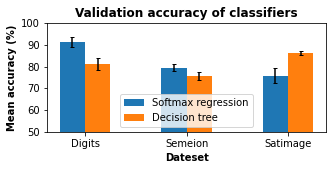

In [99]:
acc_softmax = [acc_digits_sm[0],acc_semeion_sm[0],acc_satimage_sm[0]]
err_softmax = [acc_digits_sm[1],acc_semeion_sm[1],acc_satimage_sm[1]]
acc_dt = [acc_digits_dt[0],acc_semeion_dt[0],acc_satimage_dt[0]]
err_dt = [acc_digits_dt[1],acc_semeion_dt[1],acc_satimage_dt[1]]

barWidth = 0.25
r1 = np.arange(len(acc_softmax)) + barWidth/2
r2 = [x + barWidth for x in r1]

plt.subplots(figsize=(5,2))

plt.bar(r1, acc_softmax, yerr=err_softmax, width=barWidth, 
        label='Softmax regression',capsize=2)
plt.bar(r2, acc_dt, yerr=err_dt, width=barWidth, 
        label='Decision tree',capsize=2)

plt.xlabel('Dateset', fontweight='bold')
plt.ylabel('Mean accuracy (%)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(acc_softmax))], ['Digits', 'Semeion', 'Satimage'])
plt.ylim((50,100))
plt.title("Validation accuracy of classifiers", fontweight='bold')
plt.legend()